In [1]:
# Imports and setup.
import grasp_opt
import mesh_utils
import numpy as np
import pypoisson
import torch
import trimesh

from matplotlib import pyplot as plt
from nerf_shared import config_parser, utils

# Setup config (since we're not running from command line).
parser = config_parser.config_parser()

# Use the teddy_bear config, but change some filepaths.
args = parser.parse_args(args=[
    '--config', 'teddy_bear/config.txt', '--basedir', '.',
    '--datadir', './nerf_shared/data/nerf_synthetic/teddy_bear'])

# nerf_shared requires us to default to cuda tensors.
torch.set_default_tensor_type(torch.cuda.FloatTensor)

# I <3 autoreload.
%load_ext autoreload
%autoreload 2

In [2]:
# Load nerf models, params from checkpoint.
coarse_model, fine_model = utils.create_nerf_models(args)
optimizer = utils.get_optimizer(coarse_model, fine_model, args)
utils.load_checkpoint(coarse_model, fine_model, optimizer, args, checkpoint_index=-1)
images, poses, render_poses, hwf, i_split, K, bds_dict = utils.load_datasets(args)

# Override the bounds dict by hand (bug in nerf_shared loading).
bds_dict = {'near': 0.2, 'far':1.0}
renderer = utils.get_renderer(args, bds_dict)
H, W, focal = hwf

Found ckpts ['./teddy_bear/010000.tar', './teddy_bear/020000.tar', './teddy_bear/030000.tar', './teddy_bear/040000.tar', './teddy_bear/050000.tar', './teddy_bear/060000.tar', './teddy_bear/070000.tar', './teddy_bear/080000.tar', './teddy_bear/090000.tar', './teddy_bear/100000.tar', './teddy_bear/110000.tar', './teddy_bear/120000.tar', './teddy_bear/130000.tar', './teddy_bear/140000.tar', './teddy_bear/150000.tar', './teddy_bear/160000.tar', './teddy_bear/170000.tar', './teddy_bear/180000.tar', './teddy_bear/200000.tar']
Reloading from ./teddy_bear/200000.tar
/media/data/pculbert/Documents/nerf_grasping
Loaded blender (112, 400, 400, 4) torch.Size([40, 4, 4]) [400, 400, 555.5555155968841] ./nerf_shared/data/nerf_synthetic/teddy_bear
Not ndc!
{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(),

In [100]:
n_f = 3
num_samples=100
noise_std = 0.0025

grasp_points = 0.05*torch.randn(n_f,3)
grasp_points.requires_grad = True
opt = torch.optim.Adam([grasp_points])

def clip_loss(grasp_points, lb=100., ub=200.):
    d = grasp_opt.nerf_densities(fine_model, grasp_points)
    return torch.mean(torch.maximum(torch.zeros_like(d), torch.maximum(lb-d, d-ub)))

for ii in range(500):
    opt.zero_grad()
    # G = grasp_opt.grasp_matrix(fine_model, grasp_points)
    # loss = 1e-3*torch.square(clip_loss(grasp_points))# -torch.min(torch.linalg.svdvals(G))
    d = grasp_opt.nerf_densities(fine_model, grasp_points)
    gps = grasp_points.reshape(1, n_f, 3) + noise_std * torch.randn(num_samples, n_f, 3)
    loss = clip_loss(gps) + grasp_opt.msv(fine_model, gps)
    loss.backward()
    # print(grasp_points[0].grad)
    # print(grasp_opt.nerf_densities(fine_model, grasp_points))
    if ii % 10 == 0: print(loss, torch.mean(d), grasp_points)
    opt.step()

tensor(79.2723, grad_fn=<AddBackward0>) tensor(78.2728, grad_fn=<MeanBackward0>) tensor([[ 0.0497,  0.0536,  0.1086],
        [ 0.0156, -0.0475, -0.0260],
        [-0.0184, -0.0321,  0.0045]], requires_grad=True)
tensor(32.2896, grad_fn=<AddBackward0>) tensor(112.7596, grad_fn=<MeanBackward0>) tensor([[ 0.0422,  0.0571,  0.1152],
        [ 0.0182, -0.0399, -0.0340],
        [-0.0202, -0.0328,  0.0113]], requires_grad=True)
tensor(13.1759, grad_fn=<AddBackward0>) tensor(134.4967, grad_fn=<MeanBackward0>) tensor([[ 0.0394,  0.0571,  0.1173],
        [ 0.0134, -0.0394, -0.0380],
        [-0.0241, -0.0361,  0.0172]], requires_grad=True)
tensor(9.8722, grad_fn=<AddBackward0>) tensor(136.7018, grad_fn=<MeanBackward0>) tensor([[ 0.0381,  0.0564,  0.1169],
        [ 0.0126, -0.0407, -0.0415],
        [-0.0268, -0.0339,  0.0179]], requires_grad=True)
tensor(9.7775, grad_fn=<AddBackward0>) tensor(124.8266, grad_fn=<MeanBackward0>) tensor([[ 0.0376,  0.0559,  0.1168],
        [ 0.0116, -0.0408, -

In [101]:
gt_mesh = trimesh.load(
    'nerf_shared/data/nerf_synthetic/teddy_bear/bear_demo.glb',
    force='mesh')
T = trimesh.transformations.euler_matrix(np.pi/2, 0., 0.,'rxyz')
gt_mesh.apply_transform(T)

primitive has no mode! trying GL_TRIANGLES?
primitive has no mode! trying GL_TRIANGLES?
primitive has no mode! trying GL_TRIANGLES?
concatenating texture: may result in visual artifacts


<trimesh.Trimesh(vertices.shape=(5236, 3), faces.shape=(6371, 3))>

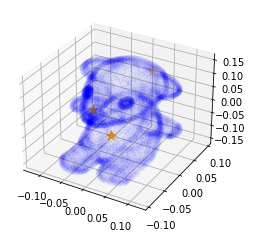

In [102]:
plane = 'xy'
level = 0.

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(*[gt_mesh.triangles_center[:, ii] for ii in range(3)], c='blue', alpha=0.025)
ax.scatter([grasp_points[ii,0].cpu().detach() for ii in range(3)],
           [grasp_points[ii,1].cpu().detach() for ii in range(3)],
           [grasp_points[ii,2].cpu().detach() for ii in range(3)],
           marker='*', s=100, c='orange')
# ax.set_title('Density Contours, ' + plane + '-plane, ' + str(level))
# plt.rcParams['font.size'] = '20'
# ax.axis('off')
plt.show()

In [71]:
print(grasp_opt.nerf_grads(fine_model, grasp_points))
print(grasp_opt.nerf_densities(fine_model, grasp_points))

opt.zero_grad()
loss = torch.sum(torch.norm(g) fo r
loss.backward()
grasp_points[0].grad
opt.step()

print(grasp_opt.nerf_densities(fine_model, grasp_points))


SyntaxError: invalid syntax (3921528846.py, line 5)

In [73]:
grasp_points

tensor([[ 0.0128, -0.0739, -0.0815],
        [-0.0380, -0.0607,  0.0463],
        [ 0.0466, -0.0137, -0.0653]], requires_grad=True)

tensor(102.8788, grad_fn=<MeanBackward0>)

tensor([[239.1823]], grad_fn=<SelectBackward0>)

tensor([[-0.0546, -0.0136,  0.0049],
        [-0.0726, -0.0406, -0.0145],
        [-0.0693, -0.0243, -0.0063],
        [-0.0537, -0.0190, -0.0028],
        [-0.0668, -0.0419, -0.0085],
        [-0.0600, -0.0263, -0.0115],
        [-0.0583, -0.0200, -0.0079],
        [-0.0457, -0.0200, -0.0075],
        [-0.0661, -0.0330, -0.0189],
        [-0.0488, -0.0332, -0.0007]], grad_fn=<AddBackward0>)
